In [1]:
%matplotlib notebook
########################################
#00     I/O                            #
#   a- import code.                    #
#   b- associate files to variables,   # 
#   c- read input files into df's.     #
########################################

#a
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import warnings; warnings.simplefilter('ignore')

#b
codes_dtypes ="datain/MRTS_Dtypes.csv"
codes_months ="datain/MRTS_months.csv"
codes_cats ="datain/MRTS_cats.csv"
codes_geo ="datain/MRTS_geo.csv"
codes_err ="datain/MRTS_errors.csv"
#data_in = "datain/MRTS_data.csv"        # contains "(S)" in some (non-E commrecord) "val" cells.
data_in2 = "datain/MRTS_data2.csv"       # this does not, otherwise same

#c
geo_df = pd.read_csv(codes_geo)     #currently only 1 code, not merging
err_df = pd.read_csv(codes_err)     #currently no error codes, not merging 
data_df = pd.read_csv(data_in2)
cats_df = pd.read_csv(codes_cats)
months_df = pd.read_csv(codes_months)
dtypes_df = pd.read_csv(codes_dtypes)    #no key for type 0, keeping data with NaN in desc

In [2]:
##############################################################################################
# 00.1     LinePlot Function (lineplot)                                                      #
#          > Creates scatterplot, linear regression, or line over scatterplot graph.         #
#   Positional Inputs[Required]: x-axis, y-axis= x and y coordinates for data points.        #
#        xy = tuple with an x and y coordinate to annotate slope-intercept formula.          #
#   Keyword Inputs[Optional]: title- title for the graph,  x_label & y_label- axes labels,   #
#        type = "line" - produces linear regression graph only.                              #
#        type = "plot" - produces scatter plot graph only.                                   #
#        type = "both" (or any value not "line" or "plot") - produces line over scatter.     #
#                                                                                            #
#   a- ensure axes are lists for scipy call, set title and labels.                           #
#   b- if not line graph only, produce scatterplot, exit if plot only.                       #
#   c- call scipy linregress() for regression line variables, create regression line.        #
#   d- create linear regression chart.                                                       #
##############################################################################################

def lineplot (xparm,yparm,xy=(0,0),title="",x_label="",y_label="",type="both"):
#a    
    x_axis = list(xparm) 
    y_axis = list(yparm)
    #x_axis = xparm 
    #y_axis = yparm
    plt.figure(figsize=(9,5))
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

#b    
    if type != "line":
        plt.scatter(x_axis,y_axis)
        plt.show()
        if type == "plot":
            return
#c        
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_axis,y_axis)
    regress_line = slope * np.asarray(x_axis) + intercept    # convert sequence to array for floatpoint *
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
#d     
    plt.plot(x_axis, regress_line,"r-")
    plt.annotate(line_eq,xy,fontsize=12,color="r")
    plt.show()

In [3]:
##########################################################################################
# 00.2    Makeline Function (makeline)                                                   #
#          > create line chart                                                           #
#   Positional Inputs[Required]: line_x, line_y = x and y coordinates for data points.   #  
#   Keyword Inputs[Optional]: line_title = title for the graph,                          #
#                             line_xlabel & line_ylabel = axes labels,                   #
#                             line_type = graph style type.                              #
#                             line_fig = plt.figure settings.                            #
##########################################################################################

def makeline (line_x,line_y,line_title="",line_xlabel="",line_ylabel="",line_type = "seaborn",line_fig=""):
    plt.style.use(line_type)
    plt.figure()

    plt.plot(line_x, line_y)
    plt.title(line_title)
    plt.xlabel(line_xlabel)
    plt.ylabel(line_ylabel)
    plt.xlim(line_x[0], line_x[len(line_x)-1])
    plt.xticks(rotation=25)

In [4]:
###########################################################################################
#01      Create main Dataframes                                                           #
#   a- merge df's (except error & geo(currently only error code 0 and gecode 1 (US))).    #
#   b- split month and year, if year not numeric, switch with month & capitalize month.   #
#    (format of per_name changes Jan/2001 (Mmm-yy --> yy-mmm))                            #
#                            df's                                                         #
#   c- keep only sales and perchange for non-adjusted retail.
#   c- complete_df: reorder columns, dropping indexes and cat_indent, write to csv.       #
#   d- complete_sales: monthly sales records (data type code = SM).                       #
#   e- complete_perchange: monthly percentage change from previous.                       #
#   f- complete_sales (non adjusted sales): remove adjusted rows from monthly sales.   #
#      complete_perchange: non adjusted monthly percentage change.                     #
#   g- ecomm_sales: remove all but ecomm data from monthly sales, write to csv.    #
#      ecomm_perchange: remove all but ecomm data from monthly percentage change.  #    
###########################################################################################

#a
cats_merge = pd.merge(data_df,cats_df, how="inner", on=["cat_idx"])
mnth_merge = pd.merge(cats_merge,months_df, how="left", on=["per_idx"])
dtyp_merge = pd.merge(mnth_merge,dtypes_df, how="left", on=["dt_idx"])  

#b
dtyp_merge["month"], dtyp_merge["year"] = dtyp_merge['per_name'].str.split('-', 1).str
dtyp_merge["year"] = pd.to_numeric(dtyp_merge["year"])
dtyp_merge["mon/yy"] = ""
dtyp_merge["val"].astype(float)                       # convert value field for aggregation

#c
dtyp_merge =dtyp_merge[((dtyp_merge["cat_code"] == "44W72") | (dtyp_merge["cat_code"] == "4541")) &
                       ((dtyp_merge["dt_code"] == "SM") | (dtyp_merge["dt_code"] == "MPCSM")) & (dtyp_merge["is_adj"] == 0)]

for x, row in dtyp_merge.iterrows():
    if dtyp_merge["month"][x].isnumeric():            # switch month and year if new format
        mhold = dtyp_merge["year"][x]
        dtyp_merge["year"][x] = dtyp_merge["month"][x]
        dtyp_merge["month"][x] = mhold
        dtyp_merge["month"][x] = dtyp_merge["month"][x].title()     #title month so new matches old
    dtyp_merge["mon/yy"][x] = dtyp_merge["month"][x] + "/" + dtyp_merge["year"][x].astype(str)
        
dtyp_merge = dtyp_merge[(dtyp_merge["year"] >= 10) & (dtyp_merge["year"] <= 20)]
dtyp_merge.reset_index(inplace=True,drop=True)
dtyp_merge["year"] = dtyp_merge["year"] + 2000
    
#c
complete_df = pd.DataFrame({"month": dtyp_merge["month"], "year": dtyp_merge["year"], "amount": dtyp_merge["val"],
                  "dt_unit": dtyp_merge["dt_unit"], "dt_code": dtyp_merge["dt_code"], "dt_desc": dtyp_merge["dt_desc"],
                  "cat_code": dtyp_merge["cat_code"], "cat_desc": dtyp_merge["cat_desc"],"monthyear" : dtyp_merge["mon/yy"]})

complete_df.sort_values(["cat_code", "dt_code"], inplace=True,ascending=False)
complete_df.reset_index(inplace=True, drop=True)
complete_df.to_csv("Data/censusdata_complete.csv", index=False, header=True)

In [5]:
###############################################################
#
##############################################################

#a
complete_sales = complete_df[complete_df["dt_code"] == "SM"]
complete_sales["amount"] = complete_sales["amount"].astype(int)
complete_sales.reset_index(inplace=True,drop=True)

#b
complete_perchange = complete_df[complete_df["dt_code"] == "MPCSM"] 
complete_perchange.reset_index(inplace=True,drop=True)

#c
ecomm_sales = complete_sales[complete_sales["cat_code"] == "4541"]
ecomm_sales.reset_index(inplace=True,drop=True)

ecomm_perchange = complete_perchange[complete_perchange["cat_code"] == "4541"]
ecomm_perchange.reset_index(inplace=True,drop=True)


#d
comm_sales = complete_sales[complete_sales["cat_code"] == "44W72"]
comm_sales.reset_index(inplace=True,drop=True)

comm_perchange = complete_perchange[complete_perchange["cat_code"] == "44W72"]
comm_perchange.reset_index(inplace=True,drop=True)

#e
monthly_sales_both = pd.DataFrame({"month": ecomm_sales["month"], "year": ecomm_sales["year"], 
                       "ecomm sales": ecomm_sales["amount"], "instore sales": comm_sales["amount"],
                       "ecomm %":  round(ecomm_sales["amount"] / (ecomm_sales["amount"] + comm_sales["amount"]) * 100,2),
                       "total sales": ecomm_sales["amount"] + comm_sales["amount"]})


ecomm_annual_sales = ecomm_sales.groupby('year')["amount"].sum()
comm_annual_sales = comm_sales.groupby('year')["amount"].sum()
total_annual_sales = ecomm_annual_sales + comm_annual_sales
ecom_per = round((ecomm_annual_sales / total_annual_sales) * 100,2)
years = ecomm_sales.groupby('year')["year"].mean()


yearly_sales_both = pd.DataFrame({"year": years, "ecomm sales": ecomm_annual_sales, "instore sales": comm_annual_sales,
                                  "ecomm %": ecom_per, "total sales": total_annual_sales})
#f
monthly_sales_both.to_csv("Data/censusdata_monthly_sales_both.csv", index=False, header=True)
yearly_sales_both.to_csv("Data/censusdata_yearly_sales_both.csv", index=False, header=True)

<IPython.core.display.Javascript object>


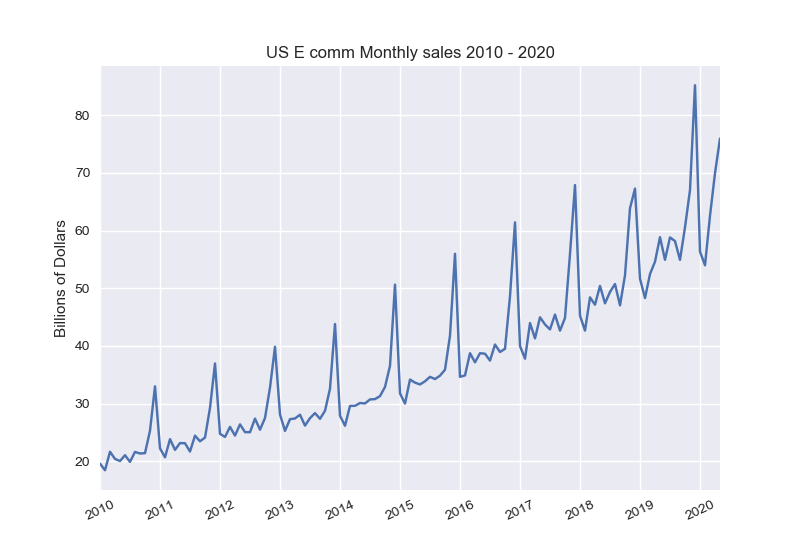

In [11]:
##############################################################
#  Sales Ten Year Monthly line Graph                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales.index
line_y = ecomm_sales["amount"] / 1000


line_xlabel = ""
line_xticks = ecomm_sales["year"].unique()




line_ylabel = "Billions of Dollars"
line_title = "US E comm Monthly sales 2010 - 2020"

plt.style.use("seaborn")
plt.figure()
plt.plot(line_x, line_y)
plt.title(line_title)
plt.xlabel(line_xlabel)
plt.ylabel(line_ylabel)
plt.xlim(line_x[0], line_x[len(line_x)-1])
plt.xticks(line_x[::12], line_xticks, rotation=25)

plt.show()
plt.savefig("Data/USCensus_ecomm_tenyear_monthly_sales.png")

<IPython.core.display.Javascript object>


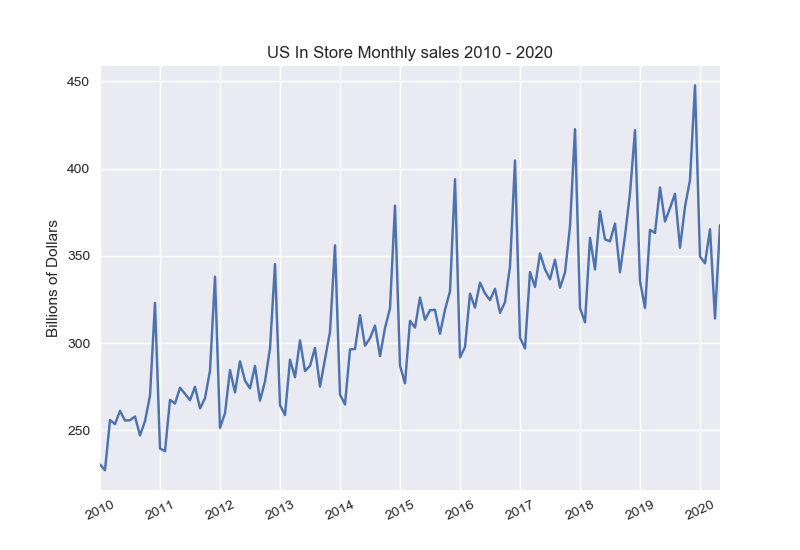

In [12]:
##############################################################
#  Sales Ten Year Monthly line Graph    instore                     #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = comm_sales.index
line_y = comm_sales["amount"] / 1000


line_xlabel = ""
line_xticks = comm_sales["year"].unique()




line_ylabel = "Billions of Dollars"
line_title = "US In Store Monthly sales 2010 - 2020"

plt.style.use("seaborn")
plt.figure()
plt.plot(line_x, line_y)
plt.title(line_title)
plt.xlabel(line_xlabel)
plt.ylabel(line_ylabel)
plt.xlim(line_x[0], line_x[len(line_x)-1])
plt.xticks(line_x[::12], line_xticks, rotation=25)

plt.show()
plt.savefig("Data/USCensus_comm_tenyear_monthly_sales.png")

In [13]:
ecomm_perchange

,month,year,amount,dt_unit,dt_code,dt_desc,cat_code,cat_desc,monthyear
0,Jan,2010,-34.2,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Jan/10
1,Feb,2010,-5.9,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Feb/10
2,Mar,2010,17.4,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Mar/10
3,Apr,2010,-5.8,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Apr/10
4,May,2010,-1.8,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,May/10
...,...,...,...,...,...,...,...,...,...
120,Jan,2020,-33.9,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Jan/20
121,Feb,2020,-4.2,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Feb/20
122,Mar,2020,15.9,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Mar/20
123,Apr,2020,11.8,PCT,MPCSM,Sales - Monthly Percent Change,4541,4541: Electronic Shopping and Mail-order Houses,Apr/20


<IPython.core.display.Javascript object>


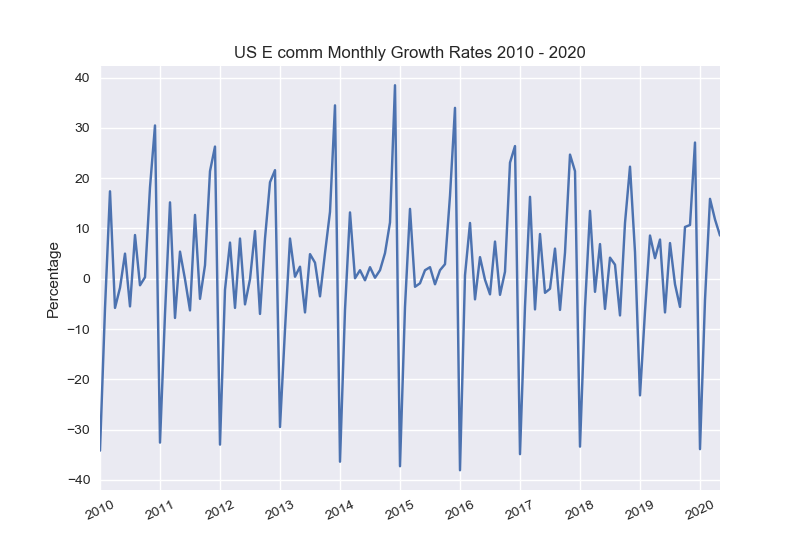

In [14]:
##############################################################
#  perchange Ten Year Monthly line Graph                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange.index
line_y = ecomm_perchange["amount"]


line_xlabel = ""
line_xticks = ecomm_perchange["year"].unique()




line_ylabel = "Percentage"
line_title = "US E comm Monthly Growth Rates 2010 - 2020"

plt.style.use("seaborn")
plt.figure()
plt.plot(line_x, line_y)
plt.title(line_title)
plt.xlabel(line_xlabel)
plt.ylabel(line_ylabel)
plt.xlim(line_x[0], line_x[len(line_x)-1])
plt.xticks(line_x[::12], line_xticks, rotation=25)

plt.show()
plt.savefig("Data/USCensus_ecomm_tenyear_monthly_growth.png")

<IPython.core.display.Javascript object>


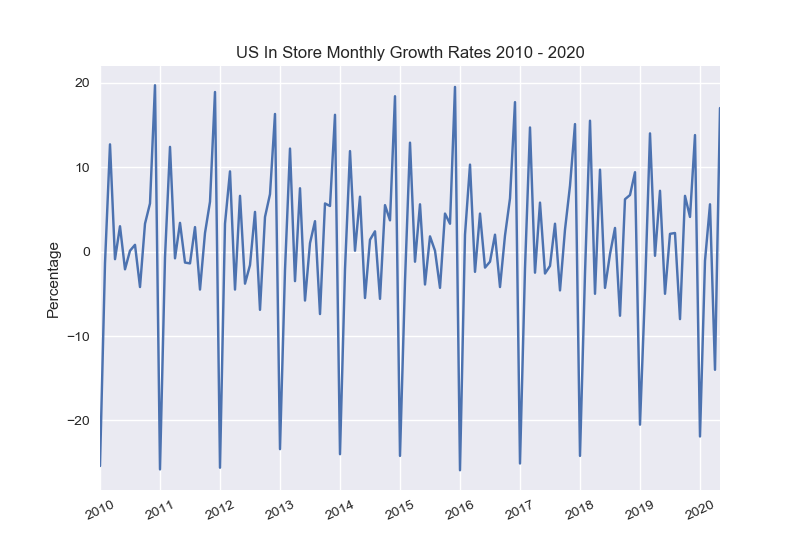

In [15]:
##############################################################
#  perchange Ten Year Monthly line Graph In Store                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = comm_perchange.index
line_y = comm_perchange["amount"]


line_xlabel = ""
line_xticks = comm_perchange["year"].unique()




line_ylabel = "Percentage"
line_title = "US In Store Monthly Growth Rates 2010 - 2020"

plt.style.use("seaborn")
plt.figure()
plt.plot(line_x, line_y)
plt.title(line_title)
plt.xlabel(line_xlabel)
plt.ylabel(line_ylabel)
plt.xlim(line_x[0], line_x[len(line_x)-1])
plt.xticks(line_x[::12], line_xticks, rotation=25)

plt.show()
plt.savefig("Data/USCensus_comm_tenyear_monthly_growth.png")

In [ ]:
#################################################################################
#02      Annual and Month Dataframes for ecomm_sales and _perchange          #
#   a- create annual ecomm monthly sales df's for past 10 full years.           #
#   b- create annual ecomm monthly change percentage change df's for 10 yrs.    #
#   c- create 10 yr df's for sales and percentage data.                         #
#   d- create 12 monthly df's with past 10 full years of monthly sales data.    #
#   e- aggregate df's of data since 2010 for montly sales.                      #
#   f- reset indexes.                                                           #
#################################################################################


#a
ecomm_sales_10 = ecomm_sales[ecomm_sales["year"] == 10]
ecomm_sales_11 = ecomm_sales[ecomm_sales["year"] == 11]
ecomm_sales_12 = ecomm_sales[ecomm_sales["year"] == 12]
ecomm_sales_13 = ecomm_sales[ecomm_sales["year"] == 13]
ecomm_sales_14 = ecomm_sales[ecomm_sales["year"] == 14]
ecomm_sales_15 = ecomm_sales[ecomm_sales["year"] == 15]
ecomm_sales_16 = ecomm_sales[ecomm_sales["year"] == 16]
ecomm_sales_17 = ecomm_sales[ecomm_sales["year"] == 17]
ecomm_sales_18 = ecomm_sales[ecomm_sales["year"] == 18]
ecomm_sales_19 = ecomm_sales[ecomm_sales["year"] == 19]
ecomm_sales_20 = ecomm_sales[ecomm_sales["year"] == 20]

#b
ecomm_perchange_10 = ecomm_perchange[ecomm_perchange["year"] == 10]
ecomm_perchange_11 = ecomm_perchange[ecomm_perchange["year"] == 11]
ecomm_perchange_12 = ecomm_perchange[ecomm_perchange["year"] == 12]
ecomm_perchange_13 = ecomm_perchange[ecomm_perchange["year"] == 13]
ecomm_perchange_14 = ecomm_perchange[ecomm_perchange["year"] == 14]
ecomm_perchange_15 = ecomm_perchange[ecomm_perchange["year"] == 15]
ecomm_perchange_16 = ecomm_perchange[ecomm_perchange["year"] == 16]
ecomm_perchange_17 = ecomm_perchange[ecomm_perchange["year"] == 17]
ecomm_perchange_18 = ecomm_perchange[ecomm_perchange["year"] == 18]
ecomm_perchange_19 = ecomm_perchange[ecomm_perchange["year"] == 19]
ecomm_perchange_20 = ecomm_perchange[ecomm_perchange["year"] == 20]




#d
ecomm_sales_Jan = ecomm_sales[ecomm_sales["month"] == "Jan"]
ecomm_sales_Feb = ecomm_sales[ecomm_sales["month"] == "Feb"]
ecomm_sales_Mar = ecomm_sales[ecomm_sales["month"] == "Mar"]
ecomm_sales_Apr = ecomm_sales[ecomm_sales["month"] == "Apr"]
ecomm_sales_May = ecomm_sales[ecomm_sales["month"] == "May"]
ecomm_sales_Jun = ecomm_sales[ecomm_sales["month"] == "Jun"]
ecomm_sales_Jul = ecomm_sales[ecomm_sales["month"] == "Jul"]
ecomm_sales_Aug = ecomm_sales[ecomm_sales["month"] == "Aug"]
ecomm_sales_Sep = ecomm_sales[ecomm_sales["month"] == "Sep"]
ecomm_sales_Oct = ecomm_sales[ecomm_sales["month"] == "Oct"]
ecomm_sales_Nov = ecomm_sales[ecomm_sales["month"] == "Nov"]
ecomm_sales_Dec = ecomm_sales[ecomm_sales["month"] == "Dec"]


#f
dfs = [ecomm_sales_10, ecomm_sales_11, ecomm_sales_12, ecomm_sales_13, ecomm_sales_14, ecomm_sales_15,
       ecomm_sales_16, ecomm_sales_17, ecomm_sales_18, ecomm_sales_19, ecomm_sales_20, ecomm_sales_Jan,
       ecomm_sales_Feb, ecomm_sales_Mar, ecomm_sales_Apr, ecomm_sales_May, ecomm_sales_Jun, ecomm_sales_Jul,
       ecomm_sales_Aug, ecomm_sales_Sep, ecomm_sales_Oct, ecomm_sales_Nov, ecomm_sales_Dec,
       ecomm_perchange_10, ecomm_perchange_11, ecomm_perchange_12, ecomm_perchange_13, ecomm_perchange_14,
       ecomm_perchange_15, ecomm_perchange_16, ecomm_perchange_17, ecomm_perchange_18, ecomm_perchange_19, 
       ecomm_perchange_20]
       
for x in dfs:
    x.reset_index(inplace=True,drop=True)

In [ ]:
##############################################################
#10.01      Sales Line Graph 2010                            #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_10["mon/yy"]
line_y = ecomm_sales_10["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2010"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2010.png")

In [ ]:
ecomm_sales_10["amount"][0]

In [ ]:
##############################################################
#10.02      Sales Line Graph 2011                            #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_11["mon/yy"]
line_y = ecomm_sales_11["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2011"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2011.png")

In [ ]:
##############################################################
#10.03      Sales Line Graph 2012                            #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_12["mon/yy"]
line_y = ecomm_sales_12["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2012"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2012.png")

In [ ]:
##############################################################
#10.04         Sales Line Graph 2013                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_13["mon/yy"]
line_y = ecomm_sales_13["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2013"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2013.png")

In [ ]:
##############################################################
#10.05         Sales Line Graph 2014                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_14["mon/yy"]
line_y = ecomm_sales_14["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2014"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2014.png")

In [ ]:
##############################################################
#10.06         Sales Line Graph 2015                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_15["mon/yy"]
line_y = ecomm_sales_15["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2015"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2015.png")

In [ ]:
##############################################################
#10.07         Sales Line Graph 2016                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_16["mon/yy"]
line_y = ecomm_sales_16["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2016"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2016.png")

In [ ]:
##############################################################
#10.08        Sales Line Graph 2017                          #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_17["mon/yy"]
line_y = ecomm_sales_17["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2017"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2017.png")
ecomm_sales_17

In [ ]:
##############################################################
#10.09         Sales Line Graph 2018                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_18["month"]
line_y = ecomm_sales_18["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2018"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2018.png")
ecomm_sales_18

In [ ]:
##############################################################
#10.10         Sales Line Graph 2019                         #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_19["mon/yy"]
line_y = ecomm_sales_19["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2019"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2019.png")
ecomm_sales_19

In [ ]:
##############################################################
#10.11      Sales Line Graph 2020                            #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_20["month"]
line_y = ecomm_sales_20["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Monthly Sales 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.year2020.png")
ecomm_sales_20

In [ ]:
##############################################################
#10.12   Sales Ten Year line Graph January                   #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Jan["mon/yy"]
line_y = ecomm_sales_Jan["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm January Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthJan.png")

In [ ]:
##############################################################
#10.13   Sales Ten Year line Graph February                  #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Feb["mon/yy"]
line_y = ecomm_sales_Feb["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm February Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthFeb.png")

In [ ]:
##############################################################
#10.14   Sales Ten Year line Graph March                     #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Mar["mon/yy"]
line_y = ecomm_sales_Mar["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm March Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthMar.png")

In [ ]:
##############################################################
#17 10.15  Sales Ten Year line Graph April                   #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Apr["mon/yy"]
line_y = ecomm_sales_Apr["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm April Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthApr.png")

In [ ]:
##############################################################
#10.16   Sales Ten Year line Graph May                       #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_May["mon/yy"]
line_y = ecomm_sales_May["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm May Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthMay.png")

In [ ]:
##############################################################
#10.17   Sales Ten Year line Graph June                      #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Jun["mon/yy"]
line_y = ecomm_sales_Jun["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm June sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthJun.png")

In [ ]:
##############################################################
#10.18   Sales Ten Year line Graph July                      #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Jul["mon/yy"]
line_y = ecomm_sales_Jul["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm July sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthJul.png")

In [ ]:
##############################################################
#10.19   Sales Ten Year line Graph August                    #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Aug["mon/yy"]
line_y = ecomm_sales_Aug["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm August sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthAug.png")

In [ ]:
##############################################################
#10.20   Sales Ten Year line Graph September                 #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Sep["mon/yy"]
line_y = ecomm_sales_Sep["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm September sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthSep.png")

In [ ]:
##############################################################
#10.21   Sales Ten Year line Graph October                   #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Oct["mon/yy"]
line_y = ecomm_sales_Oct["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm October sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthOct.png")

In [ ]:
##############################################################
#10.22   Sales Ten Year line Graph November                  #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Nov["mon/yy"]
line_y = ecomm_sales_Nov["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm November sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthNov.png")

In [ ]:
##############################################################
#10.23  Sales Ten Year line Graph December                   #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_Dec["mon/yy"]
line_y = ecomm_sales_Dec["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm December sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.monthDec.png")

In [ ]:
##############################################################
#10.25  Sales Ten Year line Graph annual avgs                #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_grp["year"]
line_y = ecomm_sales_grp["sales_mean"]
line_xlabel = ""                       # self defined by ticks (year) 
line_ylabel = "Millions of Dollars"
line_title = "US E comm Annual Sales averages:  2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.tenyear.avg.png")

In [ ]:
ecomm_sales_grp

In [ ]:
##############################################################
#10.26  Sales Ten Year line Graph annual totals               #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_sales_grp["year"]
line_y = ecomm_sales_grp["sales_total"]/1000
line_xlabel = ""                       # self defined by ticks (year) 
line_ylabel = "Billions of Dollars"
line_title = "US E comm Annual Sales Totals:  2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.tenyear.sum.png")

In [ ]:
##############################################################
#20.01      Perchange Line Graph 2010                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_10["mon/yy"]
line_y = ecomm_perchange_10["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2010"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2010.png")

In [ ]:
##############################################################
#20,02      Perchange Line Graph 2011                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_11["mon/yy"]
line_y = ecomm_perchange_11["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2011"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2011.png")

In [ ]:
##############################################################
#20.03      Perchange Line Graph 2012                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_12["mon/yy"]
line_y = ecomm_perchange_12["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2012"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2012.png")

In [ ]:
##############################################################
#20.04      Perchange Line Graph 2013                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_13["mon/yy"]
line_y = ecomm_perchange_13["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2013"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2013.png")

In [ ]:
##############################################################
#20.05      Perchange Line Graph 2014                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_14["mon/yy"]
line_y = ecomm_perchange_14["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2014"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2014.png")

In [ ]:
##############################################################
#20.06      Perchange Line Graph 2015                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_15["mon/yy"]
line_y = ecomm_perchange_15["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2015"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2015.png")

In [ ]:
##############################################################
#20.07      Perchange Line Graph 2016                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_16["mon/yy"]
line_y = ecomm_perchange_16["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2016"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2016.png")

In [ ]:
##############################################################
#20.08      Perchange Line Graph 2017                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_17["mon/yy"]
line_y = ecomm_perchange_17["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2017"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2017.png")

In [ ]:
##############################################################
#20.09      Perchange Line Graph 2018                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_18["mon/yy"]
line_y = ecomm_perchange_18["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2018"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2018.png")

In [ ]:
##############################################################
#20.10      Perchange Line Graph 2019                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_19["mon/yy"]
line_y = ecomm_perchange_19["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2019"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2019.png")

In [ ]:
##############################################################
#20.11      Perchange Line Graph 2020                        #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_20["mon/yy"]
line_y = ecomm_perchange_20["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change2020.png")

In [ ]:
##############################################################
#20.12      Perchange Line Graph 2010-2020                   #
#   a- set up variables for linegraph and call makeline().   #
#   b- display graph and write out as .png file.             #
##############################################################

#a
line_x = ecomm_perchange_tenyear["mon/yy"]
line_y = ecomm_perchange_tenyear["amount"]
line_xlabel = ""                       # self defined by ticks (mon/yy) 
line_ylabel = "Perrcentage"
line_title = "US E comm Monthly Changes in Sales 2010 - 2020"
makeline (line_x,line_y,line_title,line_xlabel,line_ylabel)

#b
plt.show()
plt.savefig("Data/USCensus.change.tenyearmonthly.png")

In [ ]:
ecomm_perchange_tenyear_grp

In [ ]:
##########################################################
#0    Matplot Bar Graph                                 #
#  a- group data by drug type, create lists for graph.   #
#  b- create bar graph, add title and labels.            #
##########################################################

#a
plt.figure()
fig, axes = plt.subplots()
plt.plot(ecomm_sales["mon/yy"], ecomm_sales["amount"])
#plt.bar(ecomm_sales["mon/yy"], ecomm_sales["amount"])
plt.title("Number of Mice per Drug Regimen")
plt.ylabel("Number of Mice")
plt.xticks
#plt.axes.Axes.set_xtick(plt.get_xticks()[::2])
#plt.xticks(drug_grp2_drugs, rotation=25)
#plt.ylim(0, max(drug_grp2_mice)+2)
plt.show()
plt.savefig("Data/test1.png")

In [ ]:
#############################################
#0  Regression1 10 year monthly            # 
#   a- set datapoints, title, and labels.   #
#   b- call lineplot() to produce graph.    #
#############################################


#a
x1 = ecomm_sales["year"].mean()
y1 = ecomm_sales["amount"].mean()
title1 = "Ten year monthly E Comm sales in millions"
xlabel1 = "Month/Year"
ylabel1 = "Millions of Dollars"
xy1 = (20,60)

#b
lineplot(x1, y1, xy1, title=title1, x_label=xlabel1, y_label=ylabel1, type="plot")
#plt.savefig("output_data/north_lat_vs_maxtemp.png")

In [ ]:
plt.scatter(ecomm_sales["mon/yy"],ecomm_sales["amount"].astype(float))
#plt.show()
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(ecomm_sales["mon/yy"],
ecomm_sales["year"].astype(float))
regress_line = slope * np.asarray(x_axis) + intercept    # convert sequence to array for floatpoint *
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
#d     
  #  plt.plot(x_axis, regress_line,"r-")
#plt.show()

In [ ]:
#############################################
#12  Regression1 North lat vs Maxtemp       # 
#   a- set datapoints, title, and labels.   #
#   b- call lineplot() to produce graph.    #
#############################################

#a
x12 = north_city_weather["lat"]
y12 = north_city_weather["maxtemp"]
title12 = "Northern Hemisphere:  Max Temp vs. Latitude"
xlabel12 = "Latutude"
ylabel12 = "Temperature (F)"
xy12 = (20,60)

#b
lineplot(x12, y12, xy12, title=title12, x_label=xlabel12, y_label=ylabel12, type="both")
#plt.savefig("Data/north_lat_vs_maxtemp.png")

In [ ]:
###############################################################
#07     Matlab Pie Chart                                      #
#  a- group data by sex, create variables with mouse count.   #
#  b- pie chart showing male/female mice.                     #
###############################################################

#a
female_df = mouse_metadata.loc[mouse_metadata["Sex"] == "Female"]
female_ct = len(female_df)
male_df = mouse_metadata.loc[mouse_metadata["Sex"] == "Male"]
male_ct = len(male_df)

#b
plt.figure()
plt.pie([female_ct, male_ct],startangle=45,autopct="%1.1f%%",labels= ["Female","Male"])
plt.title("Mice in Study")
plt.show()

In [ ]:
##########################################################
#05    Matplot Bar Graph                                 #
#  a- group data by drug type, create lists for graph.   #
#  b- create bar graph, add title and labels.            #
##########################################################

#a
drug_grp2 = mouse_metadata.groupby("Drug Regimen")
drug_grp2_mice = drug_grp2["Mouse ID"].count()
drug_grp2_drugs = [drug[0] for drug in drug_grp2["Drug Regimen"].unique()]

#b
plt.figure()
plt.bar(drug_grp2_drugs, drug_grp2_mice)
plt.title("Number of Mice per Drug Regimen")
plt.ylabel("Number of Mice")
plt.xticks(drug_grp2_drugs, rotation=25)
plt.ylim(0, max(drug_grp2_mice)+2)
plt.show()

In [ ]:
plt.style.use("seaborn")
#car_data.plot(kind="scatter", x="horsepower", y="mpg", grid=True, figsize=(8,8),
 #             title="MPG Vs. Horsepower")
#plt.show()
print(plt.style.available)

In [ ]:
for x in range (10,21) :
    try:
        ecomm_perchange_tenyear_grp["yearly_change"][x] = ((ecomm_sales_eleven[(ecomm_sales_eleven["month"] == "Jan") 
                                              & (ecomm_sales_eleven["year"] == x )]["amount"]) /
        (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                              & (ecomm_sales_eleven["year"] == x-1 )]["amount"])-1)
    except (ValueError):
        if x == 20:
            ecomm_perchange_tenyear_grp["yearly_change"][20] = ((ecomm_sales_eleven[(ecomm_sales_eleven["month"] == "Jan") 
                                              & (ecomm_sales_eleven["year"] == 20 )]["amount"]) /
        (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                              & (ecomm_sales_eleven["year"] == 19 )]["amount"])-1)
ecomm_perchange_tenyear_grp

In [ ]:
#g
ecomm_perchange_tenyear_grp["yearly_change"] = 0.0 
ecomm_perchange_tenyear_grp["current"] = 0.0
ecomm_perchange_tenyear_grp["previous"] = 0.0
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

for x in range (10,21) :
   # ecomm_perchange_tenyear_grp["current"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == "Jan") 
    #                                      & (ecomm_sales_eleven["year"] == x )]["amount"])
#
 #   ecomm_perchange_tenyear_grp["previous"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
  #                                        & (ecomm_sales_eleven["year"] == x-1 )]["amount"])

    ecomm_perchange_tenyear_grp["yearly_change"][x] = ((ecomm_sales_eleven[(ecomm_sales_eleven["month"] == "Jan") 
                                          & (ecomm_sales_eleven["year"] == x )]["amount"]) /
    (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                          & (ecomm_sales_eleven["year"] == x-1 )]["amount"])-1)
    
    
                                                         
    
#   
#     ecomm_perchange_tenyear_grp["yearly_change"][x] = (ecomm_perchange_tenyear_grp["current"][x] /
#                                                         ecomm_perchange_tenyear_grp["previous"][x] -1)
#


In [ ]:
ecomm_perchange_tenyear_grp["yearly_change"] = 0.0 
ecomm_perchange_tenyear_grp["current"] = 0.0
ecomm_perchange_tenyear_grp["previous"] = 0.0
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
#x = 10 
for x in range (10,21) :
    try:
        ecomm_perchange_tenyear_grp["current"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                          & (ecomm_sales_eleven["year"] == x )]["amount"])

        ecomm_perchange_tenyear_grp["previous"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                          & (ecomm_sales_eleven["year"] == x-1 )]["amount"])

        ecomm_perchange_tenyear_grp["yearly_change"][x] = (ecomm_perchange_tenyear_grp["current"][x] /
                                                         ecomm_perchange_tenyear_grp["previous"][x] -1)

    except (ValueError):
        if x == 20:
             ecomm_perchange_tenyear_grp["yearly_change"][20] = (ecomm_perchange_tenyear_grp["current"][x] /
                                                         ecomm_perchange_tenyear_grp["previous"][x] -1)
            
    print(x)

In [ ]:
x=19
months = ("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")
ecomm_perchange_tenyear_grp["yearly_change"] = 0.0
ecomm_perchange_tenyear_grp["current"] = 0.0
ecomm_perchange_tenyear_grp["previous"] = 0.0

ecomm_perchange_tenyear_grp["current"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                      & (ecomm_sales_eleven["year"] == x )]["amount"])

ecomm_perchange_tenyear_grp["previous"][x] = (ecomm_sales_eleven[(ecomm_sales_eleven["month"] == months[x-10]) 
                                      & (ecomm_sales_eleven["year"] == x-1 )]["amount"])

ecomm_perchange_tenyear_grp["yearly_change"][x] = (ecomm_perchange_tenyear_grp["current"][x] /
                                                     ecomm_perchange_tenyear_grp["previous"][x] -1)

ecomm_perchange_tenyear_grp

In [ ]:
import requests
url = "https://api.census.gov/data/timeseries/eits/mrts?get=data_type_code,time_slot_id,seasonally_adj,category_code,cell_value,error_data&for=us:*&time=2012&key=ded42d0ff4582b2f25d31cf7de9d9f87b3d952cf"
response = requests.get(url)

In [ ]:
response.json()